# Evaluation d'une collection
Ce script propose quelques pistes pour une évaluation automatique d'une collection. Il se fonde sur un échantillon de 200 livres.

Ce script ne peut pas être utilisé tel quel. Il ne gère pas par exemple les séries ou les cas où la bibliothèque possèderait plusieurs exemplaires.

Les critères utilisés sont les suivants:
* Date de publication: score maximum 500
* Date de réception: score maximum 2000
* Date de dernier prêt: score maximum 1000
* Nombre de prêts / année de reception: score maximum 1000
* Nombre de documents du réseau: score maximum 500

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/exemplaires.csv')

In [3]:
df

,MMS Id,Network Id,Holding Id,Barcode,Permanent Call Number,Material Type,Receiving Date (Calendar),Last Loan Date (not In House) (calendar),Num of Loans (Not In House),Publication Date,Title
0,991000364019705514,991025178609705501,2284167700005514,1072117166,128 WEI,Book,2016-11-15,NaN,"7,0",2017,Simplicité l'art d'aller à l'essentiel
1,991000112519705514,991144226709705501,2279925280005514,1070995775,372.4 CAU,Book,2020-05-21,NaN,"1,0",2000,"Qui a lu petit, lira grand"
2,991001882429705514,991016703539705501,2286024890005514,1071707044,658.403 8 LES 2010,Book,2018-03-17,NaN,"12,0",2010,Gestion de l'information [qualité de l'informa...
3,991001859049705514,991018473319705501,2281389070005514,1071818724,006.3 JAN,Book,2018-12-14,NaN,"0,0",2011,Ontology-based meta-mining of knowledge discov...
4,991000260179705514,991020560399705501,2284944640005514,1072116935,658.872 ISA 2017,Book,2017-01-15,2022-03-11,"16,0",2017,E-commerce vers le commerce connecté
...,...,...,...,...,...,...,...,...,...,...,...
195,991000399719705514,991037291279705501,2284386370005514,1071476805,174.9 MAD,Book,2018-04-19,NaN,"8,0",2007,Ethique professionnelle
196,991001619599705514,991134779609705501,2280826670005514,1071849042,658.15 FINa,Book,2018-01-01,NaN,"2,0",2013,Financial risk manager (FRM) part I
197,991000464249705514,991066015289705501,2280412530005514,1071817706,378 JOIa,Book,2019-07-04,NaN,"19,0",2009,Joint and double degree programs an emerging m...
198,991001110069705514,991118217109705501,2281565110005514,1071731034,495.1 XIN workbook,Book,2017-06-15,NaN,"2,0",2010,Xin shiyong hanyu keben = New practical Chines...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   MMS Id                                    200 non-null    int64 
 1   Network Id                                200 non-null    int64 
 2   Holding Id                                200 non-null    int64 
 3   Barcode                                   200 non-null    int64 
 4   Permanent Call Number                     200 non-null    object
 5   Material Type                             200 non-null    object
 6   Receiving Date (Calendar)                 200 non-null    object
 7   Last Loan Date (not In House) (calendar)  37 non-null     object
 8   Num of Loans (Not In House)               200 non-null    object
 9   Publication Date                          200 non-null    object
 10  Title                                     200 non-

## Croisement avec les données du réseau
Le but est de connaître le nombre d'exemplaires d'autres bibliothèques.

Plus il y a d'exemplaires disponibles en bibliothèques, moins il est intéressant
de conserver le document.

In [5]:
dg = pd.read_csv('data/NZ_nb_items.csv')

In [6]:
dg

,Network Id,Num of Items (In Repository)
0,991000367849705501,4.0
1,991001291829705501,4.0
2,991002277689705501,2.0
3,991002418839705501,4.0
4,991002666019705501,2.0
...,...,...
193,991156338429705501,1.0
194,991159016229705501,4.0
195,991160115429705501,3.0
196,991161219059705501,1.0


In [7]:
dg.columns = ['Network Id', 'Num in network']

In [8]:
dg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Network Id      198 non-null    int64  
 1   Num in network  198 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.2 KB


In [9]:
df = df.merge(dg, on='Network Id', how='left')
df

,MMS Id,Network Id,Holding Id,Barcode,Permanent Call Number,Material Type,Receiving Date (Calendar),Last Loan Date (not In House) (calendar),Num of Loans (Not In House),Publication Date,Title,Num in network
0,991000364019705514,991025178609705501,2284167700005514,1072117166,128 WEI,Book,2016-11-15,NaN,"7,0",2017,Simplicité l'art d'aller à l'essentiel,12.0
1,991000112519705514,991144226709705501,2279925280005514,1070995775,372.4 CAU,Book,2020-05-21,NaN,"1,0",2000,"Qui a lu petit, lira grand",4.0
2,991001882429705514,991016703539705501,2286024890005514,1071707044,658.403 8 LES 2010,Book,2018-03-17,NaN,"12,0",2010,Gestion de l'information [qualité de l'informa...,3.0
3,991001859049705514,991018473319705501,2281389070005514,1071818724,006.3 JAN,Book,2018-12-14,NaN,"0,0",2011,Ontology-based meta-mining of knowledge discov...,1.0
4,991000260179705514,991020560399705501,2284944640005514,1072116935,658.872 ISA 2017,Book,2017-01-15,2022-03-11,"16,0",2017,E-commerce vers le commerce connecté,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,991000399719705514,991037291279705501,2284386370005514,1071476805,174.9 MAD,Book,2018-04-19,NaN,"8,0",2007,Ethique professionnelle,2.0
196,991001619599705514,991134779609705501,2280826670005514,1071849042,658.15 FINa,Book,2018-01-01,NaN,"2,0",2013,Financial risk manager (FRM) part I,4.0
197,991000464249705514,991066015289705501,2280412530005514,1071817706,378 JOIa,Book,2019-07-04,NaN,"19,0",2009,Joint and double degree programs an emerging m...,3.0
198,991001110069705514,991118217109705501,2281565110005514,1071731034,495.1 XIN workbook,Book,2017-06-15,NaN,"2,0",2010,Xin shiyong hanyu keben = New practical Chines...,8.0


## Date de publication

In [10]:
# La date de publication est une chaîne de caractères de format variable. Il faut trouver 4 chiffres de suite.
# Une expression régulière est une solution efficace.
df['Nb years from publication'] = df['Publication Date'].apply(lambda y: 2022-int(re.search(r'\d{4}', y).group(0)))

In [11]:
# Pour le calcul du score, plus ce nombre est grand, moins il faut attribuer de points. La date de publication ne doit
# pas être trop valorisée non plus. On peut avoir une courbe assez linéaire.
df['Score publication'] = df['Nb years from publication'].apply(lambda v: 500 / (v + 1)**0.5)

## Date de réception

In [12]:
# La date est fournie au format yyyy-mm-dd. Le plus simple est de transformer en date et d'extraire l'année.
df['Nb years from receiving'] = 2022 - pd.to_datetime(df['Receiving Date (Calendar)']).dt.year

In [13]:
# Pour le calcul du score, plus ce nombre est grand, moins il faut attribuer de points. La date de réception
# influence grandement la décision. Le bonus pour un document qui vient d'être acheté doit être important.
df['Score reception'] = df['Nb years from receiving'].apply(lambda v: 2000 / (v + 1))

## Nombre de prêts par an

In [14]:
# Le nombre de prêts est fournit en string avec une virgule
df['Num of Loans (Not In House)'] = df['Num of Loans (Not In House)'].apply(lambda x: x.split(',')[0]).astype(int)

In [15]:
# nb prêts par an
df['Nb loans / year'] = df['Num of Loans (Not In House)'] / (df['Nb years from receiving'] + 1)

In [16]:
# Plus ce chiffre est élevé plus il doit être récompensé.
df['Loans score'] = df['Nb loans / year'].apply(lambda v: (v / (v + 1)) * 1000)

## Année dernier prêt

In [17]:
# Cette colonne comporte beaucoup de valeurs manquante. L'année 2000 servira à compléter cette colonne.
df['Last Loan Date (not In House) (calendar)'] = df['Last Loan Date (not In House) (calendar)'].fillna('2000-01-01')

# Même traitement que pour l'année de réception
df['Nb years from last loan'] = 2022 - pd.to_datetime(df['Last Loan Date (not In House) (calendar)']).dt.year

In [18]:
# Plus cette année est petite, plus le bonus est grand
df['Last loan score'] = df['Nb years from last loan'].apply(lambda v: 1000 / (v + 1))

## Nombre de documents du réseau
Plus ce nombre est petit, plus il est intéressant de conserver cet exemplaire



In [19]:
df['Network items score'] = df['Num in network'].apply(lambda v: 500/(v+1)**2)

## Total des points

In [20]:
df['Score total'] = df['Score publication'] + df['Score reception'] + df['Loans score'] + df['Last loan score'] + df['Network items score']

In [21]:
# L'intérêt des percentiles est de permettre l'élimination d'une collection en fonction d'un pourcentage cible.
df['Percentile'] = df['Score total'].rank(pct=True)

In [22]:
df = df.sort_values(by='Percentile')

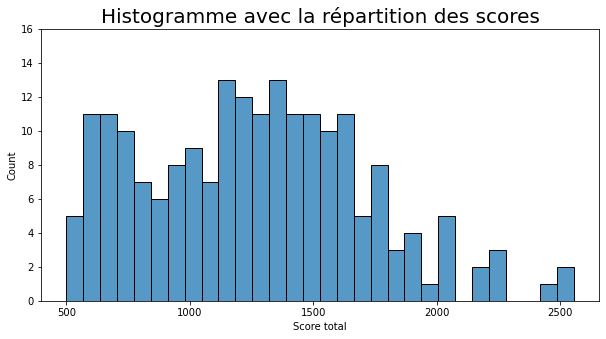

In [23]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Score total', bins=30)
plt.title('Histogramme avec la répartition des scores', fontsize=20)
_ = plt.yticks(np.arange(0, 17, 2))

In [24]:
# Export des données
df.to_excel('data/collection_evaluation.xlsx', index=False)